In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [29]:
#preparing gp data
all_sits_goal_data = pd.read_csv('csv_files/all_sits_player_goal_data.csv')
gp_df = all_sits_goal_data[['player', 'api_id', 'season_age', 'position', 
                            'position_type', 'team', 'season', 'session', 
                            'gp', 'toi']]

#prepating shift/shift length data
shift_data = pd.read_csv('large_files/player_shifts.csv')
player_pos = pd.read_csv('csv_files/player_positions.csv')
shift_data = shift_data.merge(player_pos, on='PLAYER_ID')
shift_data = shift_data[shift_data['POS'] != 'G']
shift_per_game_df = shift_data.groupby(['GAME_ID', 'PLAYER_ID', 'POS'])\
                    ['SHIFT_NUMBER'].max().reset_index()
shift_per_game_df = shift_per_game_df.rename({'SHIFT_NUMBER': 'shifts_in_game'})

#making all the column names lower case
shift_data.columns = list(map(str.lower, shift_data.columns))
player_pos.columns = list(map(str.lower, player_pos.columns))
shift_per_game_df.columns = list(map(str.lower, shift_per_game_df.columns))
gp_df.columns = list(map(str.lower, gp_df.columns))
all_sits_goal_data.columns = list(map(str.lower, all_sits_goal_data.columns))

#create a season column for shift data from game_id
shift_data['season'] = shift_data['game_id'].astype(str).str.slice(stop=4).astype(int) + 1
shift_per_game_df['season'] = shift_data['game_id'].astype(str).str.\
                              slice(stop=4).astype(int) + 1
shift_data['season'] = (shift_data['season'] - 1).astype(str) + shift_data['season'].astype(str)
shift_per_game_df['season'] = (shift_per_game_df['season'] - 1).astype(str) + \
                              shift_per_game_df['season'].astype(str)

#create test/train sets
train_gp_df = gp_df[gp_df['season'] != 20192020]
test_gp_df = gp_df[gp_df['season'] == 20192020]
train_shift_data = shift_data[shift_data['season'] != 20192020]
test_shift_data = shift_data[shift_data['season'] == 20192020]
train_shift_per_game_df = shift_data[shift_data['season'] != 20192020]
test_shift_per_game_df = shift_data[shift_data['season'] == 20192020]

In [36]:
crosby_df = train_gp_df[train_gp_df.player == 'Sidney Crosby']
crosby_df.head()

,player,api_id,season_age,position,position_type,team,season,session,gp,toi
814,Sidney Crosby,8471675,20.0,C,F,PIT,20072008,R,53.0,1104.78
1755,Sidney Crosby,8471675,21.0,C,F,PIT,20082009,R,77.0,1690.08
2713,Sidney Crosby,8471675,22.0,C,F,PIT,20092010,R,80.0,1756.55
3680,Sidney Crosby,8471675,23.0,C,F,PIT,20102011,R,41.0,898.62
4639,Sidney Crosby,8471675,24.0,C,F,PIT,20112012,R,22.0,406.38


In [38]:
import pymc3 as pm

prior_alpha = 10
prior_beta = .1666

with pm.Model() as model:
    lambda_prior = pm.Gamma("lambda_prior", alpha=prior_alpha, beta=prior_beta)
    switch_point = pm.DiscreteUniform('bounding', lower=0, upper=82)
    
    observation = bounded_poisson("likelihood", observed=crosby_df['gp'].values)


ValueError: Observed Bound distributions are not supported. If you want to model truncated data you can use a pm.Potential in combination with the cumulative probability function.

In [25]:
shift_data['season'] = shift_data['season'].astype(str) + (shift_data['season'] + 1).astype(str)
shift_per_game_df['season'] = shift_per_game_df['season'].astype(str) + (shift_per_game_df['season'] + 1).astype(str)

In [16]:
forwards_goal_data = all_sits_goal_data[all_sits_goal_data['position'] != 'D']
defense_goal_data = all_sits_goal_data[all_sits_goal_data['position'] == 'D']

In [48]:
print("Forwards TOI summary stats")
print(forwards_goal_data['toi'].describe())
print("Defense TOI summary stats")
print(defense_goal_data['toi'].describe())

Forwards TOI summary stats
count    8164.000000
mean      671.720061
std       512.604988
min         1.430000
25%       169.095000
50%       625.665000
75%      1113.372500
max      1991.280000
Name: toi, dtype: float64
Defense TOI summary stats
count    4243.000000
mean      863.717226
std       631.214286
min         0.750000
25%       257.620000
50%       831.120000
75%      1406.635000
max      2411.950000
Name: toi, dtype: float64


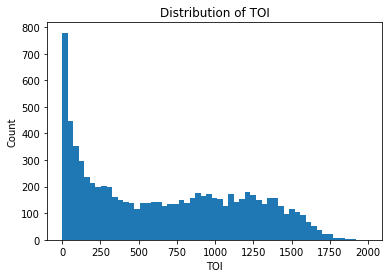

In [49]:
plt.hist(forwards_goal_data['toi'], bins=55)
plt.xlabel("TOI")
plt.ylabel("Count")
plt.title("Distribution of TOI")
plt.show()

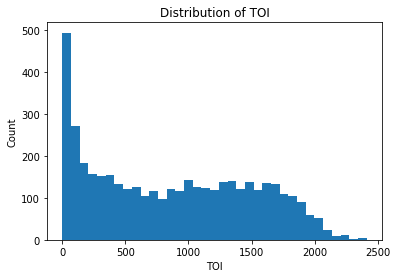

In [50]:
plt.hist(defense_goal_data['toi'], bins=35)
plt.xlabel("TOI")
plt.ylabel("Count")
plt.title("Distribution of TOI")
plt.show()

My hypothesis is that goals and points is a funtion of TOI. So I need to accurately model TOI in order model goals. So my first step will being building a TOI distribution posterior with a likelihood and prior

## Posible Distributions
* Dagum distribution
* exponential logarithmic distribution
* pareto to model the tail drop off 

In [51]:
shift_data = pd.read_csv('matt.csv')
shift_data['season'] = shift_data['GAME_ID'].astype(str).str.slice(stop=4)

In [103]:
shift_data = shift_data[shift_data.DURATION < 200]

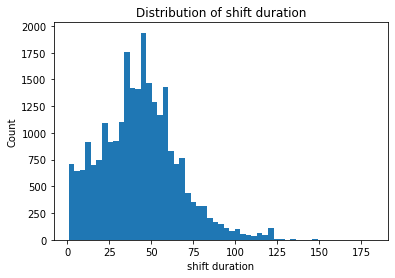

In [106]:
plt.hist(shift_data[shift_data.PLAYER_ID == 8471675]['DURATION'], bins=55)
plt.xlabel("shift duration")
plt.ylabel("Count")
plt.title("Distribution of shift duration")
plt.show()

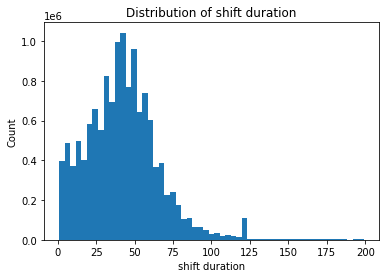

In [108]:
plt.hist(shift_data['DURATION'], bins=55)
plt.xlabel("shift duration")
plt.ylabel("Count")
plt.title("Distribution of shift duration")
plt.show()

In [112]:
print(shift_data[shift_data.PLAYER_ID == 8471675]['DURATION'].mean())
print(shift_data['DURATION'].mean())

43.111989198204995
42.193701644254034


In [115]:
shift_count = shift_data[['PLAYER_ID', 'season', 'GAME_ID', 'DURATION']]\
              .groupby(['PLAYER_ID', 'season', 'GAME_ID'], as_index=False)\
              .count().rename(columns={'DURATION': 'num_of_shifts'})

In [118]:
shift_count.num_of_shifts.max()

209

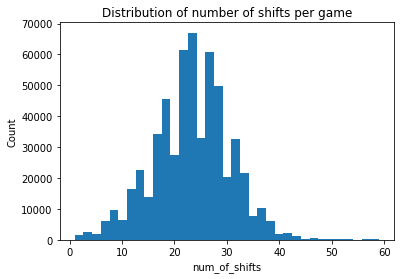

In [126]:
plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)
plt.xlabel("num_of_shifts")
plt.ylabel("Count")
plt.title("Distribution of number of shifts per game")
plt.show()

<ipython-input-127-0d2b47e1382b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)


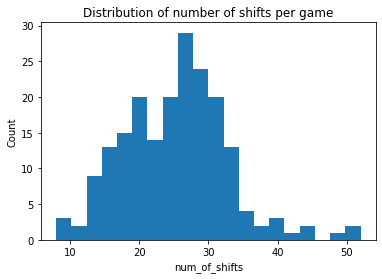

In [127]:
plt.hist(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'], bins=20)
plt.xlabel("num_of_shifts")
plt.ylabel("Count")
plt.title("Distribution of number of shifts per game")
plt.show()

In [122]:
print(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())
print(shift_count[(shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())

<ipython-input-122-6b30910bd6a3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(shift_count[(shift_data.PLAYER_ID == 8475178) & (shift_count.num_of_shifts < 60)]['num_of_shifts'].mean())


25.126903553299492
23.30448387039941


In [102]:
shift_data[(shift_data.PLAYER_ID == 8475178) & (shift_data.season == '2019')].DURATION.sum()/60

966.4666666666667

In [98]:
shift_data.GAME_ID.max()

2020030415

* Look at previous seasons goals correlation with current seasons shift count 
* for forwards previous season points and toi correlates decently with next season TOI
* for defense only really previous TOI maybe check plus minus

# Predicting Games Played
* GP is a poisson distribution with a truncated gamma conjugate prior and a negative binomial posterior predictive. The initial prior will be the gamma parameters that give an E[X] of 60 games.


In [130]:
sidney_df = all_sits_goal_data[all_sits_goal_data.player_upper == 'SIDNEY.CROSBY']
sidney_df.sort_values('season')

,player,player_upper,api_id,birthday,season_age,position,position_type,shoots,team,season,session,gp,toi,toi_gp,toi_perc,g,a1,a2,points,isf,iff,icf
814,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,20.0,C,F,L,PIT,20072008,R,53.0,1104.78,20.84,34.26,24.0,33.0,15.0,72.0,173.0,233.0,280.0
1755,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,21.0,C,F,L,PIT,20082009,R,77.0,1690.08,21.95,35.90,33.0,51.0,19.0,103.0,238.0,319.0,388.0
2713,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,22.0,C,F,L,PIT,20092010,R,80.0,1756.55,21.96,36.07,51.0,36.0,22.0,109.0,291.0,393.0,490.0
3680,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,23.0,C,F,L,PIT,20102011,R,41.0,898.62,21.92,36.09,32.0,20.0,14.0,66.0,161.0,219.0,278.0
4639,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,24.0,C,F,L,PIT,20112012,R,22.0,406.38,18.47,30.53,8.0,16.0,13.0,37.0,75.0,97.0,126.0
5545,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,25.0,C,F,L,PIT,20122013,R,36.0,759.75,21.10,34.96,15.0,28.0,13.0,56.0,124.0,168.0,203.0
6487,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,26.0,C,F,L,PIT,20132014,R,80.0,1757.78,21.97,36.19,36.0,34.0,34.0,104.0,259.0,344.0,421.0
7442,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,27.0,C,F,L,PIT,20142015,R,77.0,1538.37,19.98,32.76,28.0,31.0,25.0,84.0,237.0,315.0,380.0
8419,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,28.0,C,F,L,PIT,20152016,R,80.0,1637.55,20.47,33.66,36.0,28.0,21.0,85.0,248.0,342.0,446.0
9368,Sidney Crosby,SIDNEY.CROSBY,8471675,1987-08-07,29.0,C,F,L,PIT,20162017,R,75.0,1490.83,19.88,32.66,44.0,28.0,17.0,89.0,255.0,325.0,411.0


In [135]:
prior_alpha = 10
prior_beta = .1666

posterior_predictive_sample = np.random.negative_binomial(prior_alpha + 53, 1/(1 + (prior_beta + 1)), size=1000)

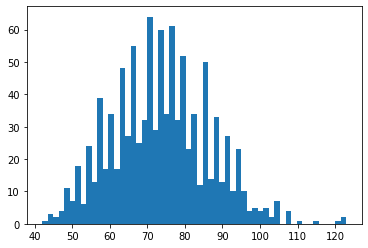

In [137]:
plt.hist(posterior_predictive_sample, bins=55)
plt.show()

In [134]:
test = np.empty(1)
print(test)

[310.80000003]


In [ ]:
games_played_samples = []

for parameter in posterior_sample:
    gp_samples = np.random.negative_binomial(parameter, size=1000)
    games_played_samples.append(gp_samples)